In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, mode
from tqdm import tqdm

from utility import print_gridworld_with_policy, print_heatmap, plot_graph

# Corridor Gridworld MDP

In [2]:
class GridworldEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    """
    This class implements a custom made Gym environment of a simple Gridworld, a NxN matrix where the agent starts from a starting position I, with an
    additional corridor situated in the right bottom corner.

    The set of states S = {[x,y]| x,y ∈ [0, ..., grid_size]} or {}, represent the possible positions in the environment.
    The set of actions A = [up, down, left, right].
    The transition to a new state T(s_t+1 | s_t, a_t).
    The reward R(s, a) = {1 if s == G else -0.1}.

    In this version the initial state is the position 0 ([0, 0]), I = [0, 0]. The goal state is the position 24 ([4, 4]) G = [4,4].

    Args:
    - grid_size: the size in height and length of the grid, N of the NxN matrix.
    - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
    - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.
    - length_corridor: the length of the corridor
    """

    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1, randomize=0, length_corridor=3):
        self.grid_size = grid_size
        self.length_corridor = length_corridor
        self.state_space = spaces.Discrete(self.grid_size ** 2 + self.length_corridor)
        self.action_space = spaces.Discrete(4)
        self.reward_range = (-0.1, 1.0)
        self.goal = (grid_size-1, grid_size-1 + length_corridor)
        self.current_pos = (0, length_corridor + grid_size - 1)
        self.done = False
        self.time_horizon = time_horizon
        self.steps_taken = 0
        self.prob = prob
        self.transition_matrix = self._build_transition_matrix()
        self.randomize = randomize
        if self.randomize == 1:
            self.current_pos = tuple(np.random.randint(0, env.grid_size, size=2))
        else:
            self.current_pos = (0, 0)

    def _build_transition_matrix(self):
        '''
        This method builds the transition matrix for the MDP, T(s'|a, s).
        The function should be used with the following order of operands:
         - first parameter: s, the state where the agent takes the action in
         - second parameter: s', the state where the agent arrives taking action a from state s
         - third parameter: a, the action taken by the agent
        '''
        transition_matrix = np.zeros((self.state_space.n, self.state_space.n, self.action_space.n))
        # For every state (i,j)
        for index in range(self.state_space.n):
            s = self.index_to_state(index)
            # For every action 'a' chosen as action from the agent
            for a in range(self.action_space.n):
                # For all actions 'a_'
                for a_ in range(self.action_space.n):
                    # Calculate the probability of
                    prob = 1 - self.prob if a_ == a else self.prob / (self.action_space.n - 1)
                    s_ = self._sample_new_position(a_, s)
                    transition_matrix[self.state_to_index(s_), self.state_to_index(s), a] += prob
        return transition_matrix

    def _sample_new_position(self, action, state):
        if action == 0:  # up
            if state[1] >= self.grid_size:
                new_pos = (state[0], state[1] - 1) # if you are in the corridor you just go one y less
            else:
                new_pos = (state[0], max(0, state[1]-1))
        elif action == 1:  # down
            if state == (self.grid_size - 1, self.grid_size - 1) or state[1] >= self.grid_size:
                new_pos = (state[0], min(self.grid_size + self.length_corridor - 1, state[1] + 1)) # if you are in the corridor, or you are entering the corridor, you add one unless you are at the end of the corridor
            else:
                new_pos = (state[0], min(self.grid_size-1, state[1]+1))
        elif action == 2:  # left
            if state[1] >= self.grid_size:
                new_pos = state # if you are in the corridor you don't move
            else:
                new_pos = (max(0, state[0]-1), state[1])
        elif action == 3:  # right
            if state[1] >= self.grid_size:
                new_pos = state # if you are in the corridor you don't move
            else:
                new_pos = (min(self.grid_size-1, state[0]+1), state[1])
        else:
            raise ValueError("Invalid action.")
        return new_pos

    def state_to_index(self, state):
        if state[1] >= self.grid_size:
            return self.grid_size ** 2 + state[1] - self.grid_size
        return state[0] + state[1] * self.grid_size

    def index_to_state(self, index):
        """Converts an index to a state tuple (i, j)."""
        if index >= self.grid_size ** 2:
            i = self.grid_size - 1
            j = self.grid_size + index - self.grid_size ** 2
            return (i, j)
        i = index % self.grid_size
        j = index // self.grid_size
        #print("Converting %d => (%d, %d)" %(index, i, j))
        return (i, j)

    def sample_next_state(self, action):
        current_state = self.state_to_index(self.current_pos)
        action_probabilities = self.transition_matrix[:, current_state, action]
        next_state_index = np.random.choice(self.state_space.n, p=action_probabilities)
        next_pos = self.index_to_state(next_state_index)
        #print("Taking action %d from cur_pos index:%d (%d, %d): going to index %d which is state => (%d, %d)" %(action, current_state, self.current_pos[0], self.current_pos[1], next_state_index, next_pos[0], next_pos[1]))
        return next_pos

    def step(self, action):
        #print("Time-step: %d" %self.steps_taken)
        if self.done:
            raise ValueError("Episode has already ended.")
        new_pos = self.sample_next_state(action)
        reward = -0.1  # default reward for moving
        if new_pos == self.goal:
            reward = 1.0
            self.done = True
        self.current_pos = new_pos
        self.steps_taken += 1
        if self.time_horizon != -1 and self.steps_taken >= self.time_horizon:
            self.done = True
        return self.current_pos, reward, self.done, {}

    def reset(self, **kwargs):
        if self.randomize == 1:
            self.current_pos = self.index_to_state(np.random.randint(0, self.state_space.n))
        else:
            self.current_pos = (0, 0)
        self.done = False
        self.steps_taken = 0
        return self.current_pos

    def render(self, mode='human'):
        if mode == 'human':
            for j in range(self.grid_size):
                for i in range(self.grid_size):
                    if (i, j) == self.current_pos:
                        print("X ", end='')
                    elif (i, j) == self.goal:
                        print("G ", end='')
                    else:
                        print("_ ", end='')
                print()
            print()

In [3]:
class GridworldEnvGoalless(GridworldEnv):
    '''
    This extension of the environment work functionally like the previous, but it removes the ending goal state.
    '''
    def step(self, action):
        #print("Time-step: %d" %self.steps_taken)
        if self.done:
            raise ValueError("Episode has already ended.")
        new_pos = self.sample_next_state(action)
        reward = -0.1  # default reward for moving
        if new_pos == self.goal:
            reward = 1.0
        self.current_pos = new_pos
        self.steps_taken += 1
        if self.time_horizon != -1 and self.steps_taken >= self.time_horizon:
            self.done = True
        return self.current_pos, reward, self.done, {}

# Reward Reinforce Agent MDP

In [4]:
# Define the REINFORCE agent
class REINFORCEAgent():
    '''
    This class is the implementation of a REINFORCE agent that tries to maximize the objective function J(θ)=E_(τ ~ p_π)[R(τ)]
    Args:
     - env: the instance of the environment on which the agent is acting.
     - alpha: the value of the learning rate to compute the policy update.
     - gamma: the value of the discount for the reward in order to compute the discounted reward.
    '''
    def __init__(self, env, alpha=0.1, gamma=0.9):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.policy_params = np.zeros((env.state_space.n, env.action_space.n))
        self.ohe_states = np.identity(env.state_space.n)

    def get_probability(self, state):
        # Compute the dot product
        params = np.dot(state, self.policy_params)
        # Compute the softmax
        probs = np.exp(params) / np.sum(np.exp(params))
        return probs

    def compute_returns(self, episode):
        G = 0
        returns = []
        for t in reversed(range(len(episode))):
            _, _, _, reward, _ = episode[t]
            G = self.gamma * G + reward
            returns.append(G)
        returns = np.array(list(reversed(returns)))
        return returns

    def get_action(self, state):
        # Get probability vector
        probs = self.get_probability(state)
        # Sample the action
        action = np.random.choice(len(probs), p=probs)
        return action, probs

    def update_single_sampling(self, episode):
        '''
        This version of the update is the Monte Carlo sampling version of the REINFORCE algorithm.

        Args:
         - episode: the sampled trajectory from which we compute the policy gradient.
        '''
        # Compute returns
        returns = self.compute_returns(episode)
        # Compute the policy gradient
        grad = np.zeros_like(self.policy_params)
        for t in range(len(episode)):
            state, action, probs, _, _ = episode[t]
            dlogp = np.zeros(self.env.action_space.n)
            for i in range(env.action_space.n):
                dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
            grad += np.outer(state, dlogp) * returns[t]
        # Update the policy parameters
        self.policy_params += self.alpha * grad

    def update_multiple_sampling(self, trajectories):
        '''
        This version of the update takes into consideration the approximation of the gradient by sampling multiple trajectories. Instead
        of working with only one trajectory it works with multiple trajectories in order to have a more accurate representation of the expected
        value of the ∇J(θ).

        Args:
         - trajectories: a list of sampled trajectories from which we compute the policy gradient.

        '''
        # Compute the policy gradient
        grad = np.zeros_like(self.policy_params)
        for episode in trajectories:
            returns = self.compute_returns(episode)
            for t in range(len(episode)):
                state, action, probs, _, _ = episode[t]
                dlogp = np.zeros(self.env.action_space.n)
                for i in range(env.action_space.n):
                    dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
                grad += np.outer(state, dlogp) * returns[t]
        grad /= len(trajectories)
        # Update the policy parameters
        self.policy_params += self.alpha * grad

**Reward MDP Single Sampling**

Starting Policy:


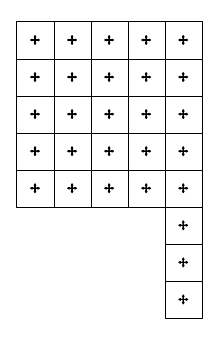

100%|████████████████████████████████████| 50000/50000 [01:21<00:00, 611.47it/s]


Ending Policy:


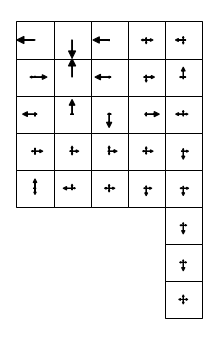

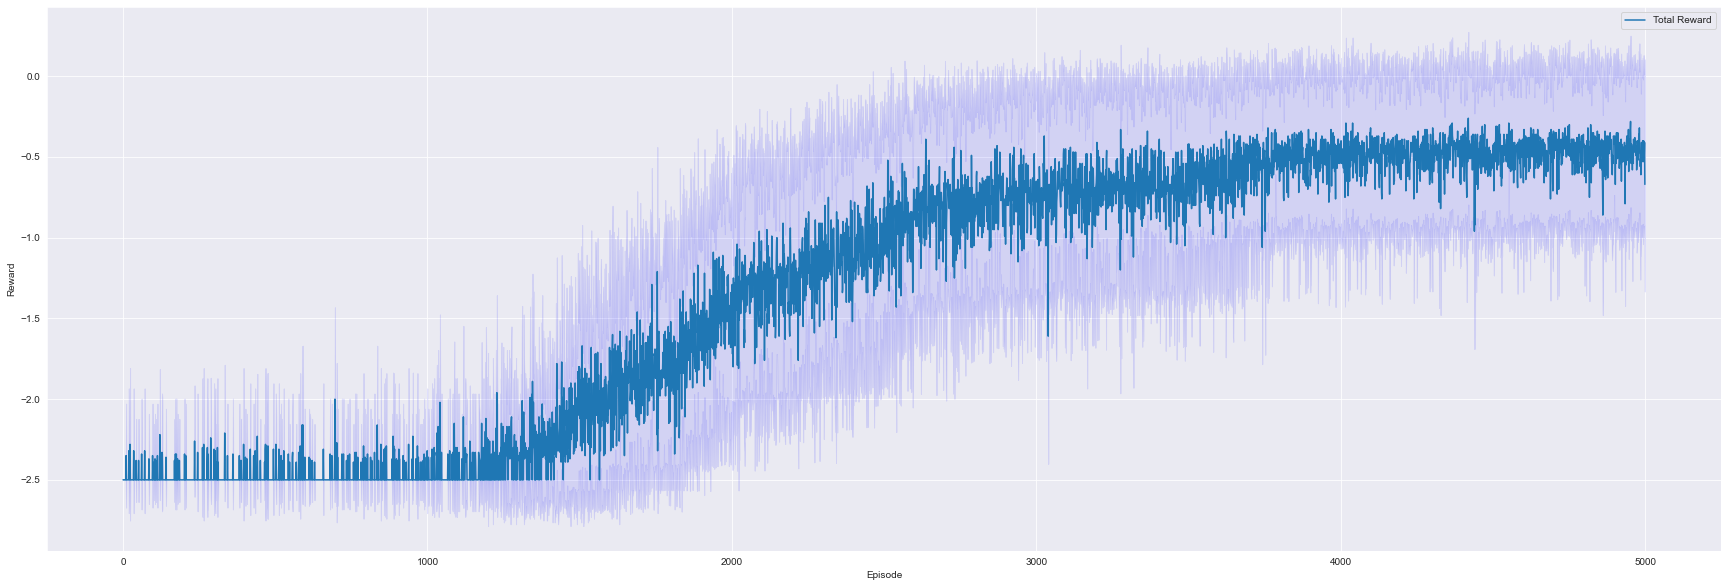

In [15]:
# Create the Gridworld environment and the REINFORCE agent
n_episodes = 5000
env = GridworldEnv(time_horizon=25)
#number of run per episode
n_run = 10
confidence = 0.95

# Create the REINFORCE agent
agent = REINFORCEAgent(env)

# Print the starting policy
print("Starting Policy:")
print_gridworld_with_policy(agent)

# Train the agent and plot the rewards
list_total_rewards = []
with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    for r in range(n_run):
        agent = REINFORCEAgent(env, alpha=0.1)
        total_rewards = []
        for i in range(n_episodes):
            episode = []
            state = env.reset()
            done = False
            total_reward = 0
            while not done:
                # Get the index of the state
                state_index = agent.env.state_to_index(state)
                # Get the one hot encoding
                ohe_state = agent.ohe_states[state_index, :]
                # Sample the action from the state
                action, probs = agent.get_action(ohe_state)
                # Take the step
                next_state, reward, done, _ = env.step(action)
                episode.append((ohe_state, action, probs, reward, next_state))
                state = next_state
                total_reward += reward
            total_rewards.append(total_reward)
            agent.update_single_sampling(episode)
            pbar.update(1)
        list_total_rewards.append(total_rewards)
list_total_rewards = np.transpose(np.array(list_total_rewards), (1, 0))

# Print the ending policy
print("Ending Policy:")
print_gridworld_with_policy(agent)

# Prepare the rewards plot
fig, ax = plt.subplots(figsize=(30, 10))
# Initialize the plotting vectors
total_rewards_means = []
under_line = []
over_line = []
for i in range(n_episodes):
    total_rewards_mean = np.mean(list_total_rewards[i])
    total_rewards_std = np.std(list_total_rewards[i])
    freedom_deg = n_run - 1
    t_crit = np.abs(t.ppf((1 - confidence) / 2, freedom_deg))
    total_rewards_means.append(total_rewards_mean)
    under_line.append(total_rewards_mean - total_rewards_std * t_crit / np.sqrt(n_run))
    over_line.append(total_rewards_mean + total_rewards_std * t_crit / np.sqrt(n_run))
ax.clear()
ax.plot(total_rewards_means, label='Total Reward')
ax.fill_between(np.arange(n_episodes), under_line, over_line, color='b', alpha=0.1)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
fig.canvas.draw()
plt.show()

100%|███████████████████████████████████████| 3000/3000 [03:41<00:00, 13.57it/s]


Ending Policy:


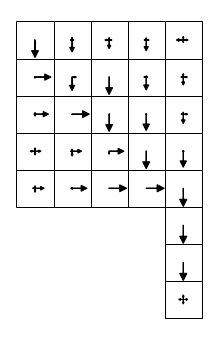

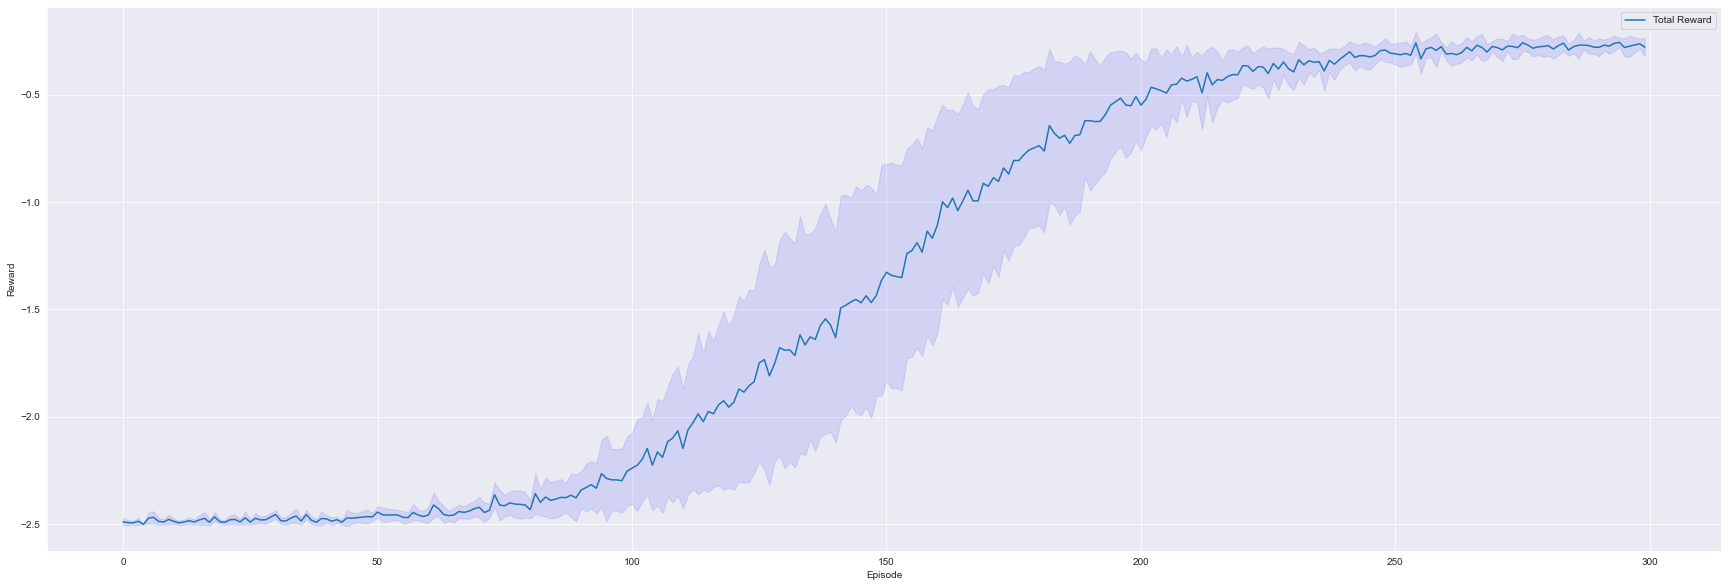

In [21]:
# Create the Gridworld environment and the REINFORCE agent
n_episodes = 300
# Number of sampled trajectories per episode
n_traj = 40
#number of run per episode
n_run = 10
confidence = 0.95

env = GridworldEnv(time_horizon=25)

# Train the agent and plot the rewards
list_total_rewards = []
with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    for r in range(n_run):
        #print("Run %d" %r)
        agent = REINFORCEAgent(env, alpha=1)
        total_avg_rewards = []
        for i in range(n_episodes):
            episodes = []
            total_rewards = []
            for k in range(n_traj):
                episode = []
                state = env.reset()
                done = False
                total_reward = 0
                while not done:
                    # Get the index of the state
                    state_index = agent.env.state_to_index(state)
                    # Get the one hot encoding
                    ohe_state = agent.ohe_states[state_index, :]
                    # Sample the action from the state
                    action, probs = agent.get_action(ohe_state)
                    # Compute the step
                    next_state, reward, done, _ = env.step(action)
                    episode.append((ohe_state, action, probs, reward, next_state))
                    state = next_state
                    total_reward += reward
                episodes.append(episode)
                total_rewards.append(total_reward)
            agent.update_multiple_sampling(episodes)
            total_avg_rewards.append(np.mean(total_rewards))
            pbar.update(1)
        list_total_rewards.append(total_avg_rewards)
list_total_rewards = np.transpose(np.array(list_total_rewards), (1,0))

# Print the ending policy
print("Ending Policy:")
print_gridworld_with_policy(agent)

# Initialize the plotting vectors
fig, ax = plt.subplots(figsize=(30,10))
total_rewards_means = []
under_line = []
over_line = []
for i in range(n_episodes):
    total_rewards_mean = np.mean(list_total_rewards[i])
    total_rewards_std = np.std(list_total_rewards[i])
    freedom_deg = n_run - 1
    t_crit = np.abs(t.ppf((1 - confidence) / 2, freedom_deg))
    total_rewards_means.append(total_rewards_mean)
    under_line.append(total_rewards_mean - total_rewards_std * t_crit / np.sqrt(n_run))
    over_line.append(total_rewards_mean + total_rewards_std * t_crit / np.sqrt(n_run))
ax.clear()
ax.plot(total_rewards_means, label='Total Reward')
ax.fill_between(np.arange(n_episodes), under_line, over_line, color='b', alpha=0.1)
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
fig.canvas.draw()

# Entropy Reinforce Agent MDP

In [5]:
class REINFORCEAgentE(REINFORCEAgent):
    '''
    This class is the extension of the previous Reinforce agent. The only change is the objective followed by the agent that this time is going
    to be the state-action visitation entropy J(θ) = E_(τ ~ p_π)[H(d_τ(s,a))] .

    Args:
         - policy:
            0: initialize the dummy policy;
            1: initialize the optimal policy;
            2: initialize the uniform policy.
    '''
    def __init__(self, env, alpha=0.1, gamma=0.9, policy=-1):
        super().__init__(env=env, alpha=alpha, gamma=gamma)
        # Optional initialization to have a non-uniform initial policy
        self.init_policy(policy)

    def init_policy(self, policy):
        if policy == 0:
            self.policy_params = self.create_dummy_policy()
        elif policy == 1:
            self.policy_params = self.create_optimal_policy()
        else:
            self.policy_params = np.ones((env.state_space.n, env.action_space.n))

    def create_dummy_policy(self):
        params = np.zeros((env.state_space.n, env.action_space.n))
        for i in range(self.env.state_space.n):
                params[i, 0] = 1
        return params

    def create_optimal_policy(self):
        params = np.zeros((env.state_space.n, env.action_space.n))
        k = 1
        actions = [3,3,3,2]
        for i in range(self.env.state_space.n):
                if i % self.env.grid_size == self.env.grid_size - 1 and (k == 1):
                    params[i, 1] = 500
                    k += 1
                elif i % self.env.grid_size == self.env.grid_size - 1 and (k == 3):
                    params[i, actions[k]] = 500
                    k = 0
                elif i % self.env.grid_size == 0 and k == 2:
                    params[i, 1] = 500
                    k += 1
                elif i % self.env.grid_size == 0 and k == 0:
                    params[i, actions[k]] = 500
                    k += 1
                else:
                    params[i, actions[k]] = 500
        return params

    def compute_entropy(self, d_t):
        # Create the condition to apply the log
        condition = d_t > 0
        # Compute log of d_t
        log_d_t = -np.log(d_t, where=condition)
        # Compute the entropy
        entropy = np.sum(np.multiply(d_t, log_d_t))
        return entropy

    def update_single_sampling(self, episode, d_t):
        # Compute entropy of d_t
        entropy = self.compute_entropy(d_t)
        # Update policy parameters using the gradient of the entropy of the t-step state distribution
        grad = np.zeros_like(self.policy_params)
        for t in range(len(episode)):
            state, action, probs, _, _ = episode[t]
            # Compute the policy gradient
            dlogp = np.zeros(self.env.action_space.n)
            for i in range(env.action_space.n):
                dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
            grad += np.outer(state, dlogp) * entropy
        grad *= entropy
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        return entropy

    def update_multiple_sampling(self, trajectories):
        # Update policy parameters using the approximated gradient of the entropy objective function
        grad = np.zeros_like(self.policy_params)
        entropies = []
        for episode, d_t in trajectories:
            # Initialize the gradient of the k-th sampled trajectory
            grad_k = np.zeros_like(self.policy_params)
            # Compute entropy of d_t
            entropy = self.compute_entropy(d_t)
            # Compute the gradient
            for t in range(len(episode)):
                state, action, probs, _, _ = episode[t]
                # Compute the policy gradient
                dlogp = np.zeros(self.env.action_space.n)
                for i in range(env.action_space.n):
                    dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
                grad_k += np.outer(state, dlogp) * entropy
            # Sum the k-th gradient to the final gradient
            grad += grad_k
            entropies.append(entropy)
        # Divide the gradient by the number of trajectories sampled
        grad /= len(trajectories)
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        return entropies

**Uniform Policy Deterministic**

 33%|████████████▋                         | 5000/15000 [07:39<14:03, 11.85it/s]

Final State Distribution:
Ending Policy:


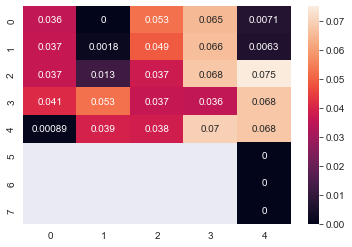

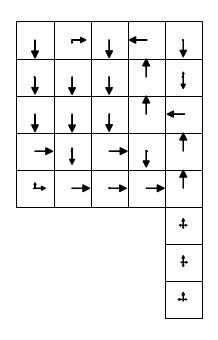

 67%|████████████████████████▋            | 10000/15000 [14:55<07:26, 11.21it/s]

Final State Distribution:
Ending Policy:


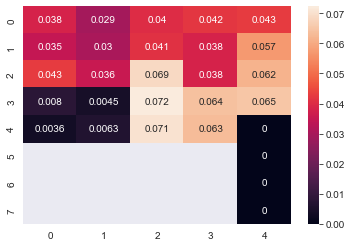

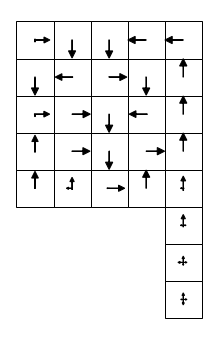

100%|█████████████████████████████████████| 15000/15000 [22:22<00:00, 10.95it/s]

Final State Distribution:
Ending Policy:


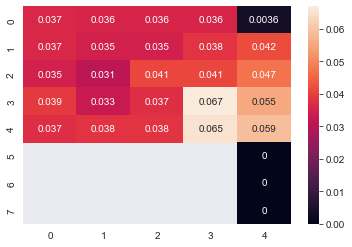

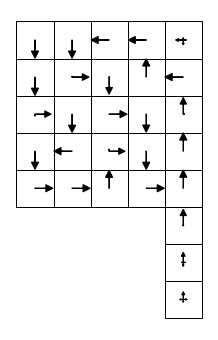

100%|█████████████████████████████████████| 15000/15000 [22:22<00:00, 11.17it/s]


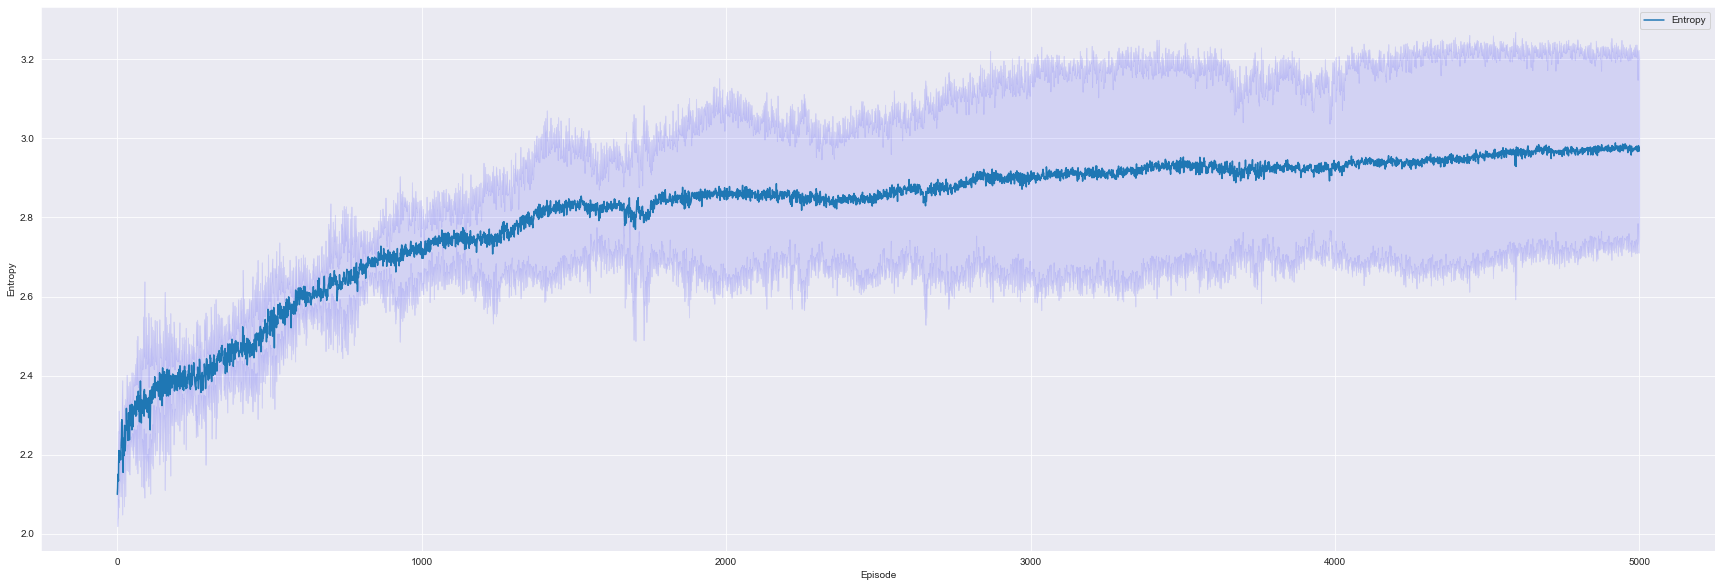

In [6]:
n_episodes = 5000
n_traj = 40
n_run = 3
confidence = 0.95
time_horizon = 28
env = GridworldEnvGoalless(time_horizon=time_horizon, prob=0)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentE(env=env, policy=2, alpha=0.2)
        avg_entropies = []
        for i in range(n_episodes):
            episodes = []
            entropies = []
            for k in range(n_traj):
                episode = []
                d_t = np.zeros(env.state_space.n)
                state = env.reset()
                done = False
                while not done:
                    # Get the index of the state
                    state_index = agent.env.state_to_index(state)
                    # Update state visitation
                    d_t[state_index] += 1
                    # Get the one hot encoding
                    ohe_state = agent.ohe_states[state_index, :]
                    # Sample the action from the state
                    action, probs = agent.get_action(ohe_state)
                    # Compute the step
                    next_state, reward, done, _ = env.step(action)
                    episode.append((ohe_state, action, probs, reward, next_state))
                    state = next_state
                d_t /= len(episode)
                episodes.append((episode, d_t))
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            pbar.update(1)
        # Visualization of policy and expected state visitation
        d_t = np.zeros(env.state_space.n)
        for i in range(n_traj):
            state = env.reset()
            done = False
            while not done:
                # Get the index of the state
                state_index = agent.env.state_to_index(state)
                # Update state visitation
                d_t[state_index] += 1
                # Get the one hot encoding
                ohe_state = agent.ohe_states[state_index, :]
                # Sample the action from the state
                action, probs = agent.get_action(ohe_state)
                # Compute the step
                next_state, reward, done, _ = env.step(action)
                state = next_state
        d_t /= (time_horizon * n_traj)
        # Print the final heatmap
        print("Final State Distribution:")
        print_heatmap(agent, d_t)
        # Print the ending policy
        print("Ending Policy:")
        print_gridworld_with_policy(agent)
        list_entropies.append(avg_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))

# Initialize the plotting vectors
fig, ax = plt.subplots(figsize=(30,10))
entropies_means = []
under_line = []
over_line = []
for i in range(n_episodes):
    entropies_mean = np.mean(list_entropies[i])
    entropies_std = np.std(list_entropies[i])
    freedom_deg = n_run - 1
    t_crit = np.abs(t.ppf((1 - confidence) / 2, freedom_deg))
    entropies_means.append(entropies_mean)
    under_line.append(entropies_mean - entropies_std * t_crit / np.sqrt(n_run))
    over_line.append(entropies_mean + entropies_std * t_crit / np.sqrt(n_run))
ax.clear()
ax.plot(entropies_means, label='Entropy')
ax.fill_between(np.arange(n_episodes), under_line, over_line, color='b', alpha=0.1)
ax.set_xlabel('Episode')
ax.set_ylabel('Entropy')
ax.legend()
fig.canvas.draw()

In [7]:
deterministic_multiple_sampling_result = entropies_means

**Uniform Policy Stochastic**

 14%|█████▏                              | 5000/35000 [12:37<1:14:22,  6.72it/s]

Final State Distribution:
Ending Policy:


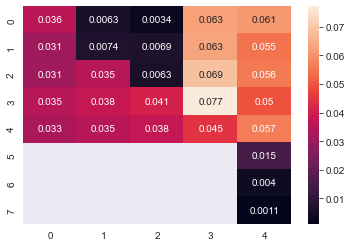

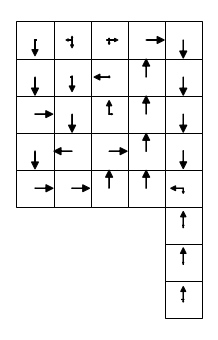

 29%|██████████                         | 10000/35000 [25:18<1:01:07,  6.82it/s]

Final State Distribution:
Ending Policy:


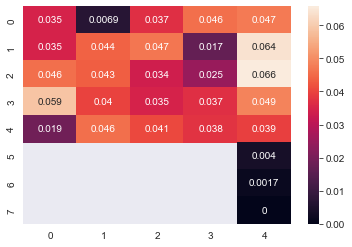

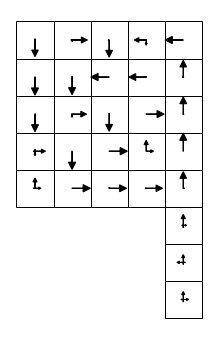

 43%|███████████████▊                     | 15000/35000 [37:53<50:36,  6.59it/s]

Final State Distribution:
Ending Policy:


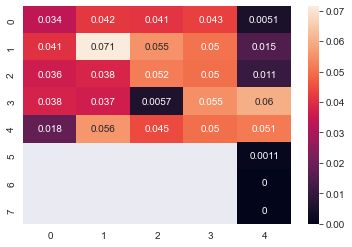

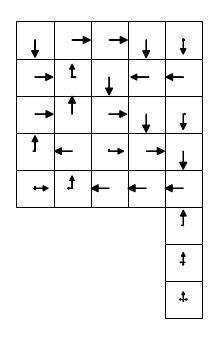

 57%|█████████████████████▏               | 20000/35000 [50:29<37:51,  6.60it/s]

Final State Distribution:
Ending Policy:


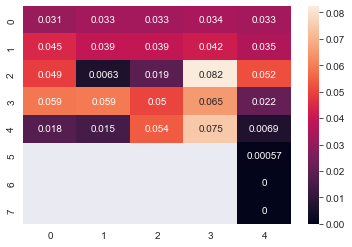

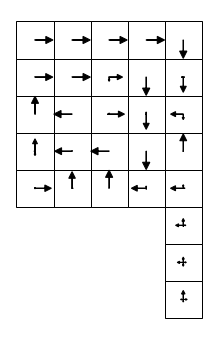

 71%|█████████████████████████          | 25000/35000 [1:03:08<24:37,  6.77it/s]

Final State Distribution:
Ending Policy:


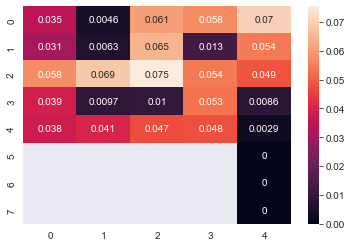

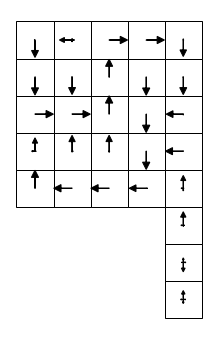

 86%|██████████████████████████████     | 30000/35000 [1:15:46<12:45,  6.53it/s]

Final State Distribution:
Ending Policy:


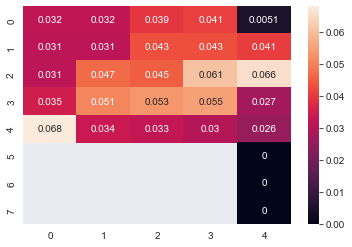

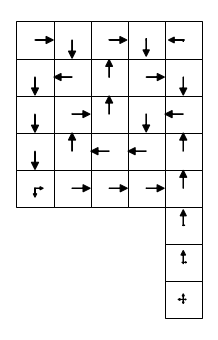

100%|███████████████████████████████████| 35000/35000 [1:28:27<00:00,  6.77it/s]

Final State Distribution:
Ending Policy:


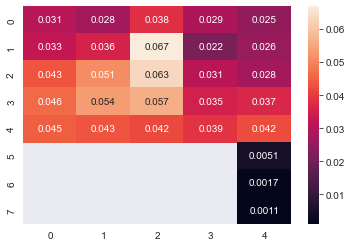

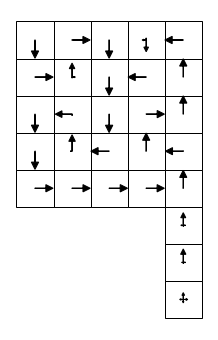

100%|███████████████████████████████████| 35000/35000 [1:28:27<00:00,  6.59it/s]


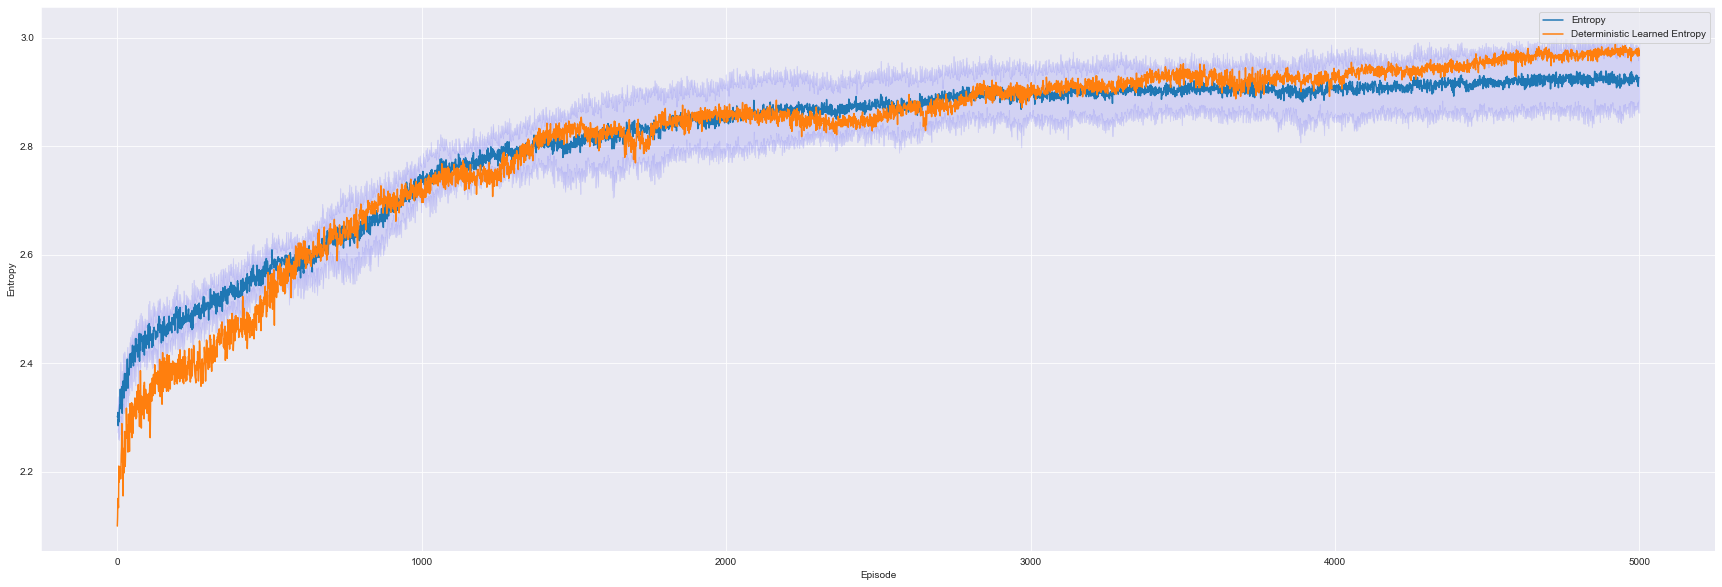

In [9]:
n_episodes = 5000
n_traj = 50
n_run = 7
confidence = 0.95
time_horizon = 35
env = GridworldEnvGoalless(time_horizon = time_horizon)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentE(env=env, policy=2, alpha=0.2)
        avg_entropies = []
        for i in range(n_episodes):
            episodes = []
            entropies = []
            for k in range(n_traj):
                episode = []
                d_t = np.zeros(env.state_space.n)
                state = env.reset()
                done = False
                while not done:
                    # Get the index of the state
                    state_index = agent.env.state_to_index(state)
                    # Update state visitation
                    d_t[state_index] += 1
                    # Get the one hot encoding
                    ohe_state = agent.ohe_states[state_index, :]
                    # Sample the action from the state
                    action, probs = agent.get_action(ohe_state)
                    # Compute the step
                    next_state, reward, done, _ = env.step(action)
                    episode.append((ohe_state, action, probs, reward, next_state))
                    state = next_state
                d_t /= len(episode)
                episodes.append((episode, d_t))
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            pbar.update(1)
        # Visualization of policy and expected state visitation
        d_t = np.zeros(env.state_space.n)
        for i in range(n_traj):
            state = env.reset()
            done = False
            while not done:
                # Get the index of the state
                state_index = agent.env.state_to_index(state)
                # Update state visitation
                d_t[state_index] += 1
                # Get the one hot encoding
                ohe_state = agent.ohe_states[state_index, :]
                # Sample the action from the state
                action, probs = agent.get_action(ohe_state)
                # Compute the step
                next_state, reward, done, _ = env.step(action)
                state = next_state
        d_t /= (time_horizon * n_traj)
        # Print the final heatmap
        print("Final State Distribution:")
        print_heatmap(agent, d_t)
        # Print the ending policy
        print("Ending Policy:")
        print_gridworld_with_policy(agent)
        list_entropies.append(avg_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))

# Initialize the plotting vectors
fig, ax = plt.subplots(figsize=(30,10))
entropies_means = []
under_line = []
over_line = []
for i in range(n_episodes):
    entropies_mean = np.mean(list_entropies[i])
    entropies_std = np.std(list_entropies[i])
    freedom_deg = n_run - 1
    t_crit = np.abs(t.ppf((1 - confidence) / 2, freedom_deg))
    entropies_means.append(entropies_mean)
    under_line.append(entropies_mean - entropies_std * t_crit / np.sqrt(n_run))
    over_line.append(entropies_mean + entropies_std * t_crit / np.sqrt(n_run))
ax.clear()
ax.plot(entropies_means, label='Entropy')
ax.plot(deterministic_multiple_sampling_result[:n_episodes], label='Deterministic Learned Entropy')
ax.fill_between(np.arange(n_episodes), under_line, over_line, color='b', alpha=0.1)
ax.set_xlabel('Episode')
ax.set_ylabel('Entropy')
ax.legend()
fig.canvas.draw()

In [10]:
stochastic_multiple_sampling_result = entropies_means

# Gridworld POMDP

In [8]:
class GridworldPOMDPEnv(GridworldEnv):
    '''
    This class implements the extension of the upper Gridworld MDP, making it become a POMDP by inserting the observation mechanism.
    The observations here are modeled as a probability of returning the real state of the MDP, in a Gaussian fashion based on the distance of the observed state from the real current state.

    Args:
     - grid_size: the size in height and length of the grid, N of the NxN matrix.
     - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
     - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.
     - steepness: a parameter to control the steepness of the Gaussian distribution that models the observation probability from the real state. A higher value makes it steeper.
    '''
    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1, randomize=0, steepness=15):
        # Initialize the underlying Gridworld MDP
        super().__init__(grid_size=grid_size, time_horizon=time_horizon, randomize=randomize, prob=prob)
        # Initialize all the POMDP specific variables
        self.observation_space = spaces.Discrete(self.state_space.n)
        self.steepness = steepness
        self.observation_matrix = self.build_observation_matrix()

    def build_observation_matrix(self):
        '''
        This method creates the observation matrix for our environment.
        The observation function indexes are to be used in order:
         - first param: true state s
         - second param: observation o
        '''
        # Initialize the observation function with zeros
        observation_matrix = np.zeros((self.state_space.n, self.state_space.n))
        # Calculate the variance of the Gaussian distribution based on the grid size
        variance = (self.grid_size + self.length_corridor // 2) ** 2

        for s_i in range(self.observation_space.n):
            for s in range(self.observation_space.n):
                # Calculate the distance between the observed position and the true state
                distance = np.linalg.norm(np.array(self.index_to_state(s_i)) - np.array(self.index_to_state(s)))
                # Assign probability based on Gaussian distribution with adjusted steepness
                observation_matrix[s_i][s] += np.exp(-self.steepness * distance**2 / (2 * variance))
            # Normalize the probabilities for each row
            observation_matrix[s_i] /= np.sum(observation_matrix[s_i])

        # Return the built matrix
        return observation_matrix

    def reset(self):
        # Call the upper reset of the environment
        super().reset()
        # Set the initial belief and give it to the agent
        initial_belief = self.observation_matrix[self.state_to_index(self.current_pos)]
        return initial_belief

    def step(self, action):
        # Save the true state
        true_state = self.current_pos
        # Make the step of the underlying MDP
        next_state, reward, done, info = super().step(action)
        # Get the index of the state
        next_state_index = self.state_to_index(next_state)
        # Get the observation probabilities for the state
        obs_prob = self.observation_matrix[next_state_index]
        # Sample the next observation from the probabilities
        obs = np.random.choice(self.observation_space.n, p=obs_prob)
        # Change index to position
        obs = self.index_to_state(obs)
        return obs, reward, done, true_state

In [9]:
class GridworldPOMDPEnvGoalless(GridworldEnvGoalless):
    '''
    This extension of the environment work functionally like the previous, but it removes the ending goal state.
    In the POMDP case it also adds the observation mechanism.
    '''
    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1, steepness=15):
        # Initialize the underlying Gridworld MDP
        super().__init__(grid_size=grid_size, time_horizon=time_horizon, prob=prob)
        # Initialize all the POMDP specific variables
        self.observation_space = spaces.Discrete(self.state_space.n)
        self.steepness = steepness
        self.observation_matrix = self.build_observation_matrix()

    def build_observation_matrix(self):
        '''
        This method creates the observation matrix for our environment.
        The observation function indexes are to be used in order:
         - first param: true state s
         - second param: observation o
        '''
        # Initialize the observation function with zeros
        observation_matrix = np.zeros((self.observation_space.n, self.observation_space.n))
        # Calculate the variance of the Gaussian distribution based on the grid size
        variance = (self.grid_size // 2) ** 2

        for s_i in range(self.observation_space.n):
            for s in range(self.observation_space.n):
                # Calculate the distance between the observed position and the true state
                distance = np.linalg.norm(np.array(self.index_to_state(s_i)) - np.array(self.index_to_state(s)))
                # Assign probability based on Gaussian distribution with adjusted steepness
                observation_matrix[s_i][s] += np.exp(-self.steepness * distance**2 / (2 * variance))
            # Normalize the probabilities for each row
            observation_matrix[s_i] /= np.sum(observation_matrix[s_i])

        # Return the built matrix
        return observation_matrix

    def reset(self):
        # Call the upper reset of the environment
        super().reset()
        # Set the initial belief and give it to the agent
        initial_belief = self.observation_matrix[self.state_to_index(self.current_pos)]
        return initial_belief

    def step(self, action):
        # Save the true state
        true_state = self.current_pos
        # Make the step of the underlying MDP
        next_state, reward, done, info = super().step(action)
        # Get the index of the state
        next_state_index = self.state_to_index(next_state)
        # Get the observation probabilities for the state
        obs_prob = self.observation_matrix[next_state_index]
        # Sample the next observation from the probabilities
        obs = np.random.choice(self.observation_space.n, p=obs_prob)
        # Change index to position
        obs = self.index_to_state(obs)
        return obs, reward, done, true_state

# Test observation matrix

[0.01094435 0.00254592 0.00039043]


IndexError: index 25 is out of bounds for axis 0 with size 25

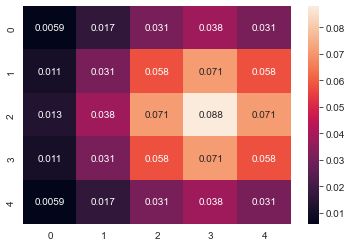

In [8]:
env = GridworldPOMDPEnv(time_horizon=100)
state = 13
sns.heatmap(np.reshape(env.observation_matrix[state][:env.grid_size**2], (env.grid_size, env.grid_size)), annot=True)
print(env.observation_matrix[state][env.grid_size**2:])

heatmap_data = np.full((env.grid_size+env.length_corridor, env.grid_size), np.nan)
for index in range(env.state_space.n):
    col, row = env.index_to_state(index)
    heatmap_data[row][col] = env.observation_matrix[state][:env.grid_size**2][index]
sns.heatmap(data=heatmap_data, annot=True)


In [10]:
class REINFORCEAgentEPOMDP(REINFORCEAgentE):
    '''
    This calls implements the Reinforce Agent for the POMDP defined above.
    It is implemented as the extension of the former MDP agent but adds the belief state and what is concerned by it.
    '''
    def __init__(self, env, alpha=0.1, gamma=0.9):
        super().__init__(env=env, alpha=alpha, gamma=gamma)
        self.belief_state = np.ones(env.observation_space.n) / env.observation_space.n
        self.n_expected_value = 30

    def belief_update(self, action, observation):
        '''
        This method updates the belief of the agent in a Bayesian way.
        '''
        # Get the index of the observed state
        obs_state_index = self.env.state_to_index(observation)

        # Get the observation probabilities for all states
        obs_probabilities = self.env.observation_matrix[:, obs_state_index]

        # Calculate the numerator: Obs(o|s) * sum_s' (P(s|s',a) * belief_state[s'])
        numerator = obs_probabilities * np.sum(self.env.transition_matrix[:, :, action] * self.belief_state, axis=1)

        # Calculate the denominator: sum_s' (Obs(o|s') * sum_s'' (P(s'|s'',a) * belief_state[s'']))
        denominator = np.sum(obs_probabilities * np.sum(self.env.transition_matrix[:, :, action] * self.belief_state, axis=1))

        # Update the belief state
        self.belief_state = numerator / denominator

    def get_state(self, belief, behaviour):
        '''
        This method is used to sample or compute the expected state given the current belief.
        Args:
         - behaviour: if 0 it returns the state from a single sampling.
                 if 1 it returns the state from multiple samplings.
                 No other values allowed.
        '''
        if behaviour != 0 and behaviour != 1:
            raise Exception("You have to pass me 0 or 1, read :/")

        if behaviour == 0:
            state = np.random.choice(belief.size, p=belief)
            state = env.index_to_state(state)
            return state

        if behaviour == 1:
            states = np.random.choice(belief.size, self.n_expected_value, p=belief)
            state = mode(states).mode[0]
            state = env.index_to_state(state)
            return state

    def play(self, env, n_traj):
        episodes = []
        true_entropies = []
        for k in range(n_traj):
            episode = []
            d_t = np.zeros(env.state_space.n)
            true_d_t = np.zeros(env.state_space.n)
            agent.belief_state = env.reset()
            done = False
            while not done:
                # Sample action and get probabilities from the belief
                action, probs = agent.get_action(agent.belief_state)
                # Sample state
                sampled_state = agent.get_state(agent.belief_state, 1)
                # Get the index of the state
                state_index = agent.env.state_to_index(sampled_state)
                # Get the one hot encoding
                ohe_state = agent.ohe_states[state_index, :]
                # Take a step of the environment
                next_obs, reward, done, true_state = env.step(action)
                # Update state visitation
                d_t[state_index] += 1
                # Update state visitation
                true_d_t[env.state_to_index(true_state)] += 1
                episode.append((agent.belief_state, action, probs, reward, true_state))
                agent.belief_update(action, next_obs)
            # Compute true entropy of the trajectory
            true_d_t /= len(episode)
            true_entropies.append(agent.compute_entropy(true_d_t))
            d_t /= len(episode)
            episodes.append((episode, d_t))
        return episodes, true_entropies

    def print_visuals(self, env, n_traj):
        # Visualization of policy and expected state visitation
        d_t = np.zeros(env.state_space.n)
        true_d_t = np.zeros(env.state_space.n)
        for i in range(n_traj):
            self.belief_state = env.reset()
            done = False
            while not done:
                # Sample action and get probabilities from the belief
                action, probs = self.get_action(self.belief_state)
                # Sample state
                sampled_state = self.get_state(self.belief_state, 1)
                # Get the index of the state
                state_index = self.env.state_to_index(sampled_state)
                # Take a step of the environment
                next_obs, reward, done, true_state = env.step(action)
                # Update state visitation
                d_t[state_index] += 1
                # Update state visitation
                true_d_t[env.state_to_index(true_state)] += 1
                agent.belief_update(action, next_obs)
        true_d_t /= (time_horizon * n_traj)
        d_t /= (time_horizon * n_traj)
        # Print the final true state heatmap
        print_heatmap(self, true_d_t, "Final True State Distribution")
        # Print the final true state heatmap
        print_heatmap(self, d_t, "Final Believed State Distribution")
        # Print the ending policy
        print_gridworld_with_policy(self, title="Ending Policy")

**Entropy POMDP**

 14%|█████▏                              | 5000/35000 [52:23<5:13:57,  1.59it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


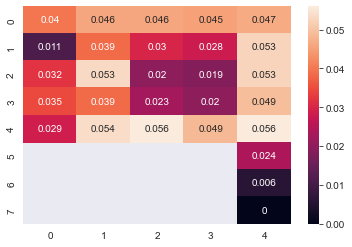

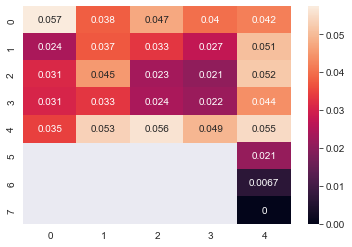

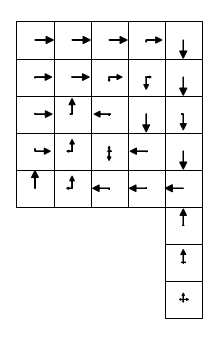

 29%|█████████▍                       | 10000/35000 [1:44:52<4:20:07,  1.60it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


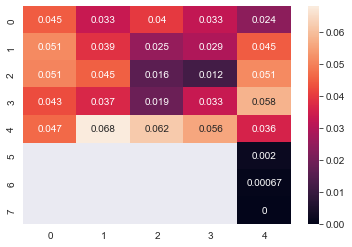

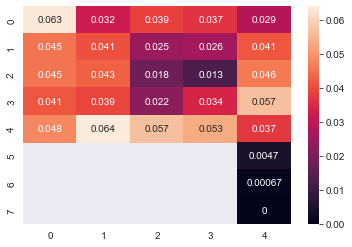

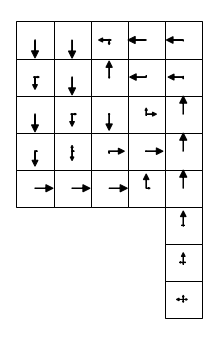

 43%|██████████████▏                  | 15000/35000 [2:40:08<3:30:32,  1.58it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


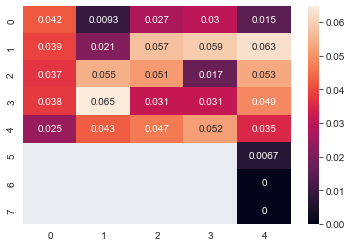

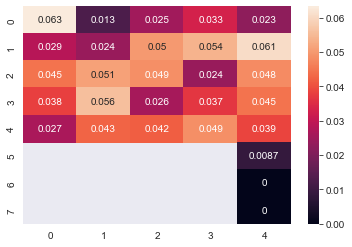

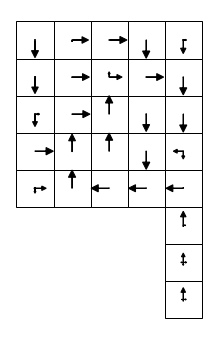

 57%|██████████████████▊              | 20000/35000 [3:32:17<2:35:30,  1.61it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


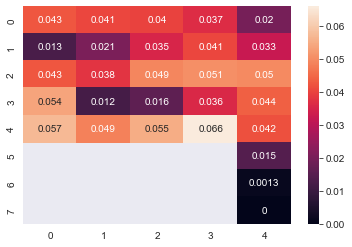

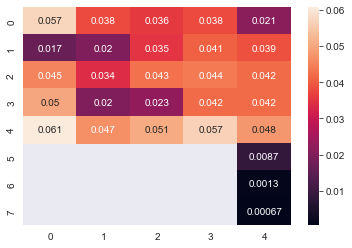

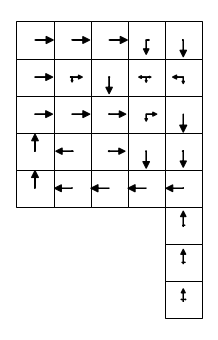

 71%|███████████████████████▌         | 25000/35000 [4:24:33<1:43:17,  1.61it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


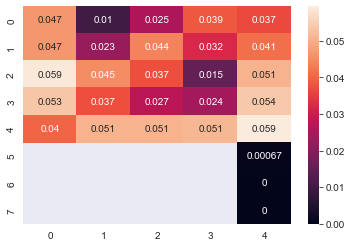

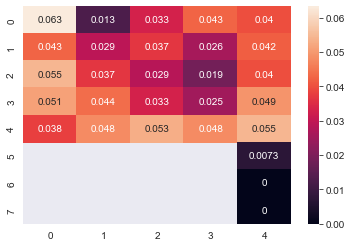

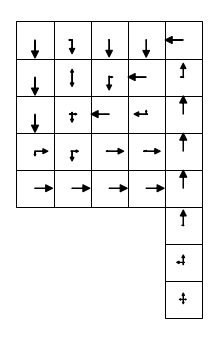

 86%|██████████████████████████████     | 30000/35000 [5:16:34<52:03,  1.60it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


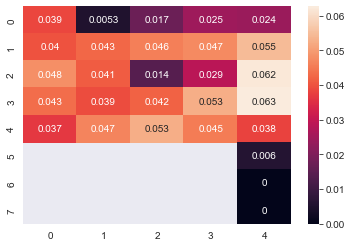

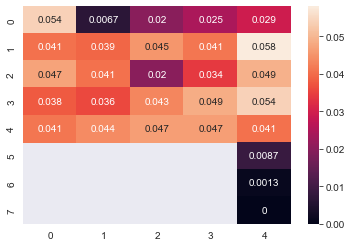

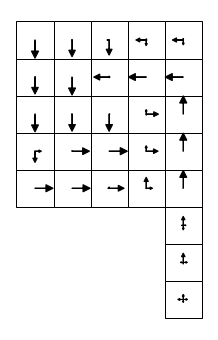

100%|███████████████████████████████████| 35000/35000 [6:09:04<00:00,  1.59it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


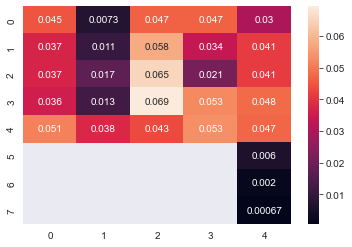

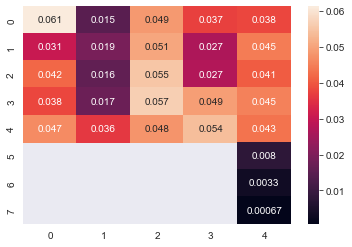

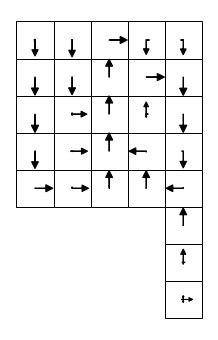

100%|███████████████████████████████████| 35000/35000 [6:09:05<00:00,  1.58it/s]


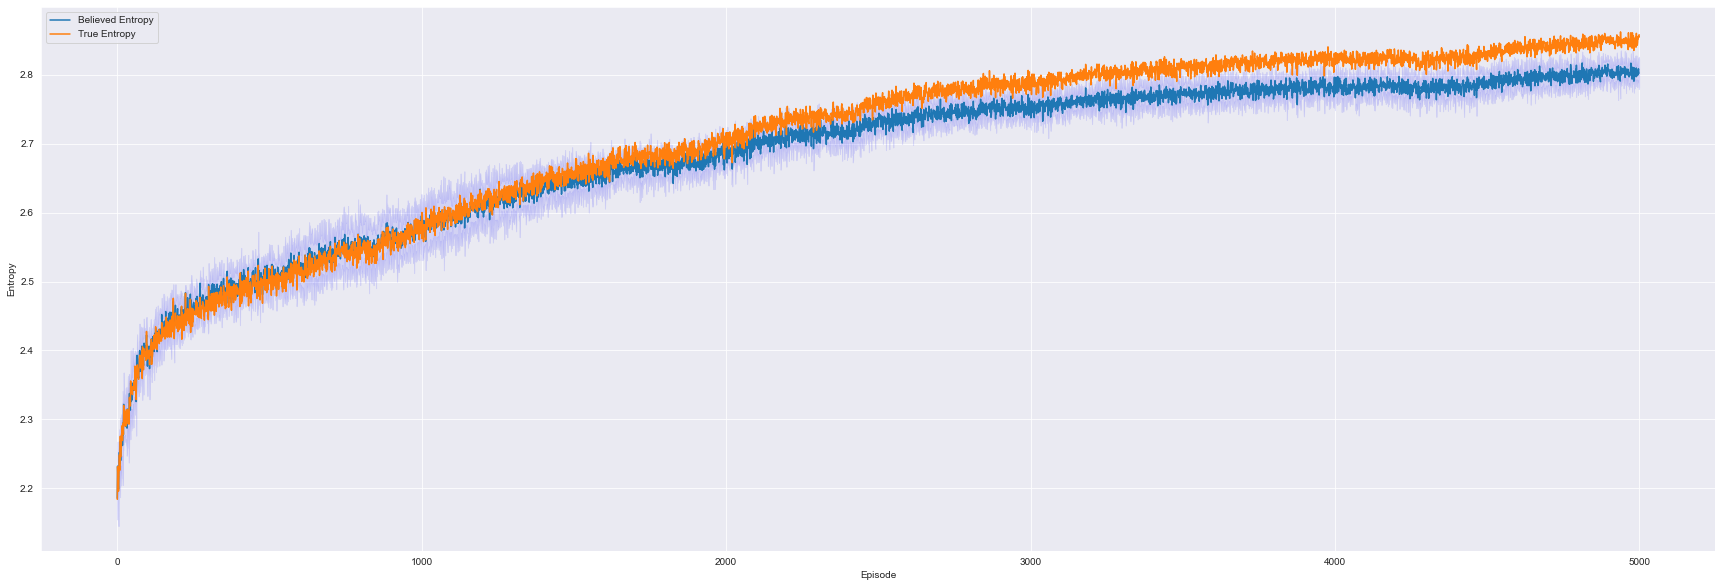

In [44]:
# Number of episodes for the training
n_episodes = 5000
n_traj = 50
# Number of runs per episode
n_run = 7
confidence = 0.95
time_horizon = 30
env = GridworldPOMDPEnvGoalless(time_horizon = time_horizon, steepness=15)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    list_true_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentEPOMDP(env, alpha = 0.5)
        avg_entropies = []
        avg_true_entropies = []
        for i in range(n_episodes):
            episodes, true_entropies = agent.play(env=env, n_traj=n_traj)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            avg_true_entropies.append(np.mean(true_entropies))
            pbar.update(1)
        agent.print_visuals(env=env, n_traj=n_traj)
        list_entropies.append(avg_entropies)
        list_true_entropies.append(avg_true_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))
    list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence)

**Less steep Gaussian**

 20%|██████▌                          | 10000/50000 [1:29:54<4:51:00,  2.29it/s]

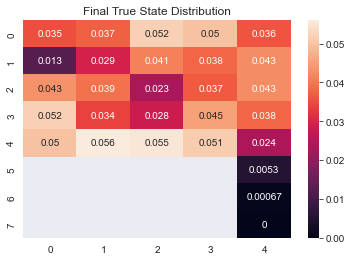

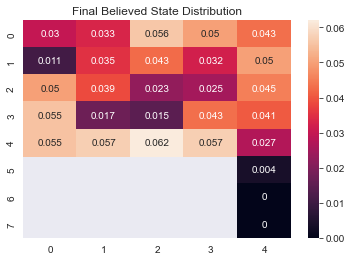

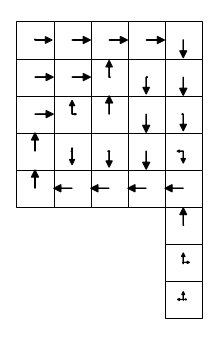

 26%|████████▍                       | 13103/50000 [1:55:30<11:45:13,  1.15s/it]

In [ ]:
# Number of episodes for the training
n_episodes = 10000
n_traj = 50
# Number of runs per episode
n_run = 5
confidence = 0.95
time_horizon = 30
env = GridworldPOMDPEnvGoalless(time_horizon = time_horizon, steepness=5)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    list_true_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentEPOMDP(env, alpha = 0.5)
        avg_entropies = []
        avg_true_entropies = []
        for i in range(n_episodes):
            episodes, true_entropies = agent.play(env=env, n_traj=n_traj)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            avg_true_entropies.append(np.mean(true_entropies))
            pbar.update(1)
        agent.print_visuals(env=env, n_traj=n_traj)
        list_entropies.append(avg_entropies)
        list_true_entropies.append(avg_true_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))
    list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence)

In [ ]:
class GridworldPOMDPEnvBiModal(GridworldEnvGoalless):
    '''
    This class implements the extension of the upper Gridworld MDP, making it become a POMDP by inserting the observation mechanism.
    The observations here are modeled as a probability of returning the real state of the MDP, in a Gaussian fashion based on the distance of the observed state from the real current state.

    Args:
     - grid_size: the size in height and length of the grid, N of the NxN matrix.
     - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
     - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.
     - steepness: a parameter to control the steepness of the Gaussian distribution that models the observation probability from the real state. A higher value makes it steeper.
    '''
    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1, randomize=0, steepness=15):
        # Initialize the underlying Gridworld MDP
        super().__init__(grid_size=grid_size, time_horizon=time_horizon, randomize=randomize, prob=prob)
        # Initialize all the POMDP specific variables
        self.shift_amount = 0.80
        self.observation_space = spaces.Discrete(self.state_space.n)
        self.steepness = steepness
        self.observation_matrix = self.build_observation_matrix()

    def build_observation_matrix(self):
        '''
        This method creates the observation matrix for our environment.
        The observation function indexes are to be used in order:
         - first param: true state s
         - second param: observation o
        '''
        # Initialize the observation function with zeros
        observation_matrix = np.zeros((self.state_space.n, self.state_space.n))
        # Calculate the variance of the Gaussian distribution based on the grid size
        variance = (self.grid_size // 2) ** 2

        for s_i in range(self.observation_space.n):
            for s in range(self.observation_space.n):
                # Calculate the distance between the observed position and the true state
                distance = np.linalg.norm(np.array(self.index_to_state(s_i)) - np.array(self.index_to_state(s)))
                # Calculate the probability for the left-shifted Gaussian
                prob_left = np.exp(-self.steepness * (distance + self.shift_amount) ** 2 / (2 * variance))
                # Calculate the probability for the right-shifted Gaussian
                prob_right = np.exp(-self.steepness * (distance - self.shift_amount) ** 2 / (2 * variance))
                # Assign probability as the sum of left-shifted and right-shifted Gaussians
                observation_matrix[s_i][s] += prob_left + prob_right

            # Normalize the probabilities for each row
            observation_matrix[s_i] /= np.sum(observation_matrix[s_i])

        # Return the built matrix
        return observation_matrix

    def reset(self):
        # Call the upper reset of the environment
        super().reset()
        # Set the initial belief and give it to the agent
        initial_belief = self.observation_matrix[self.state_to_index(self.current_pos)]
        return initial_belief

    def step(self, action):
        # Save the true state
        true_state = self.current_pos
        # Make the step of the underlying MDP
        next_state, reward, done, info = super().step(action)
        # Get the index of the state
        next_state_index = self.state_to_index(next_state)
        # Get the observation probabilities for the state
        obs_prob = self.observation_matrix[next_state_index]
        # Sample the next observation from the probabilities
        obs = np.random.choice(self.observation_space.n, p=obs_prob)
        # Change index to position
        obs = self.index_to_state(obs)
        return obs, reward, done, true_state

 33%|████████████                        | 6000/18000 [50:19<1:59:30,  1.67it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


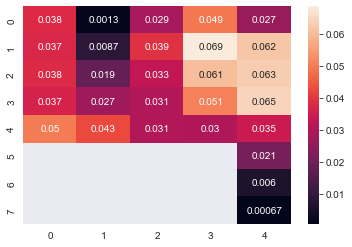

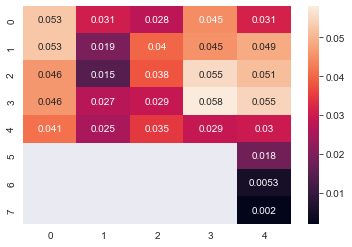

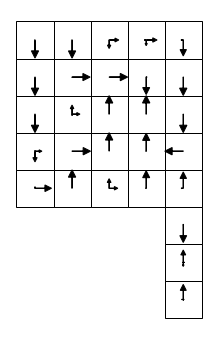

 67%|███████████████████████▎           | 12000/18000 [1:44:29<43:58,  2.27it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


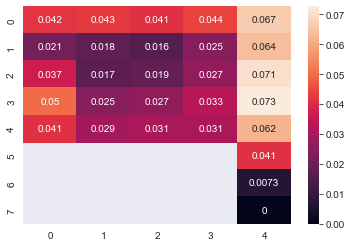

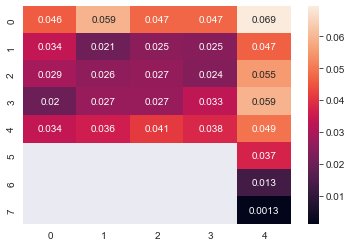

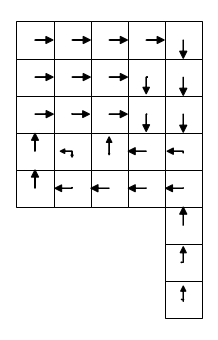

100%|███████████████████████████████████| 18000/18000 [2:38:01<00:00,  1.69it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


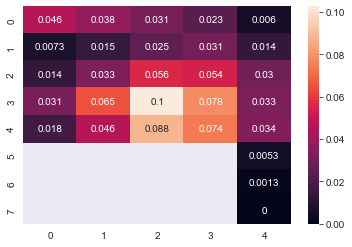

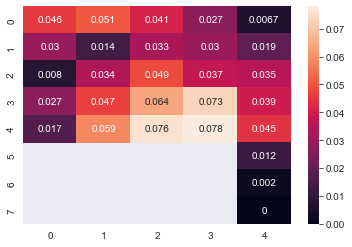

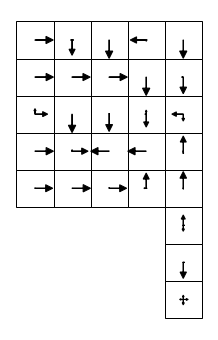

100%|███████████████████████████████████| 18000/18000 [2:38:02<00:00,  1.90it/s]


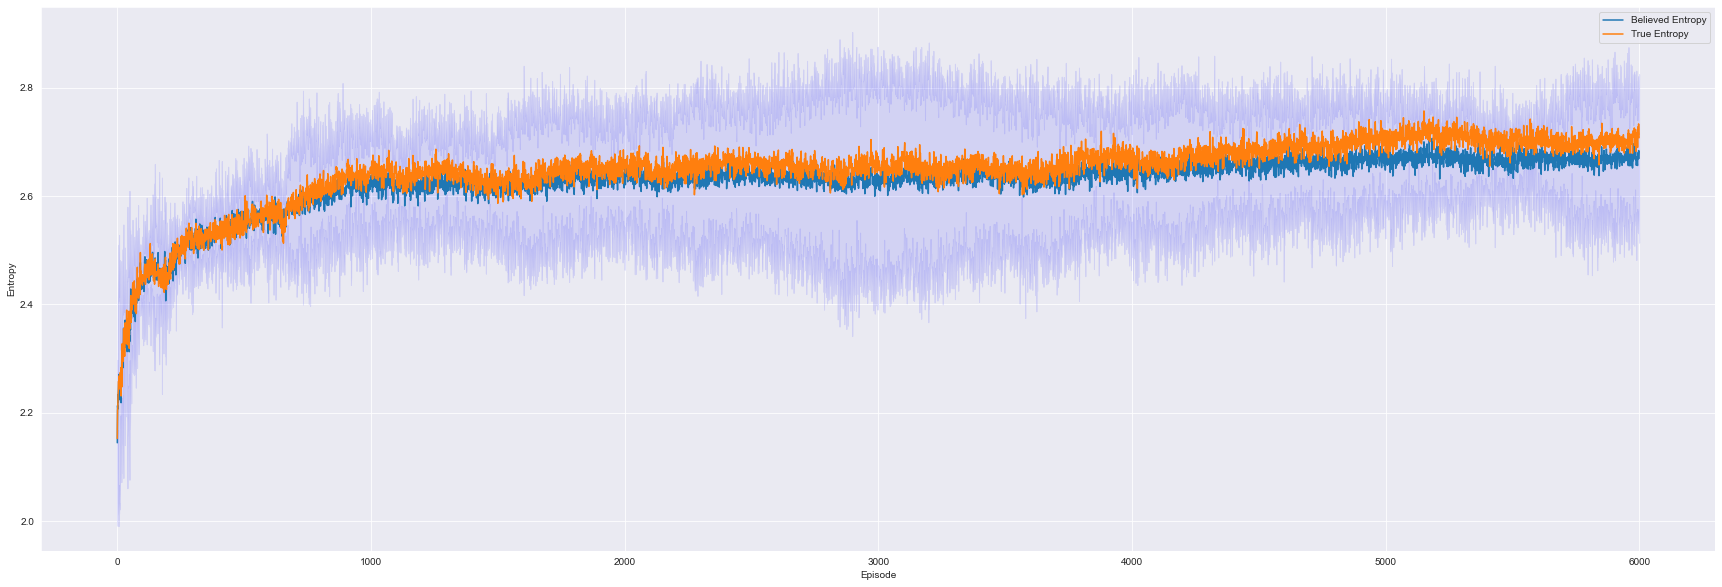

In [19]:
# Number of episodes for the training
n_episodes = 6000
n_traj = 50
# Number of runs per episode
n_run = 3
confidence = 0.95
time_horizon = 30
env = GridworldPOMDPEnvBiModal(time_horizon = time_horizon, steepness=15, prob=0.1)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    list_true_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentEPOMDP(env, alpha = 0.5)
        avg_entropies = []
        avg_true_entropies = []
        for i in range(n_episodes):
            episodes, true_entropies = agent.play(env=env, n_traj=n_traj)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            avg_true_entropies.append(np.mean(true_entropies))
            pbar.update(1)
        agent.print_visuals(env=env, n_traj=n_traj)
        list_entropies.append(avg_entropies)
        list_true_entropies.append(avg_true_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))
    list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence)

In [ ]:
# Number of episodes for the training
n_episodes = 8000
n_traj = 50
# Number of runs per episode
n_run = 3
confidence = 0.95
time_horizon = 30
env = GridworldPOMDPEnvBiModal(time_horizon = time_horizon, steepness=15, prob=0.1, randomize=1)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    list_true_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentEPOMDP(env, alpha = 0.5)
        avg_entropies = []
        avg_true_entropies = []
        for i in range(n_episodes):
            episodes, true_entropies = agent.play(env=env, n_traj=n_traj)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            avg_true_entropies.append(np.mean(true_entropies))
            pbar.update(1)
        agent.print_visuals(env=env, n_traj=n_traj)
        list_entropies.append(avg_entropies)
        list_true_entropies.append(avg_true_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))
    list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence)

 25%|████████▌                         | 8000/32000 [1:03:15<3:32:16,  1.88it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


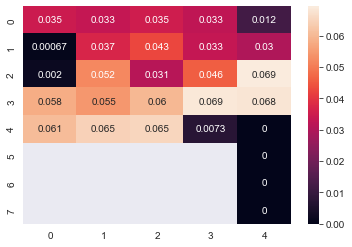

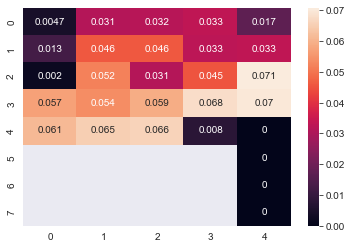

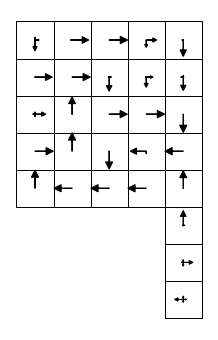

 50%|████████████████▌                | 16000/32000 [2:38:57<2:16:50,  1.95it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


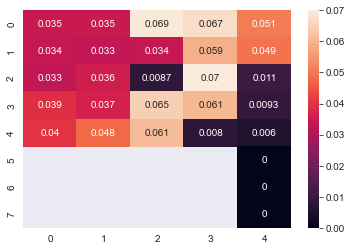

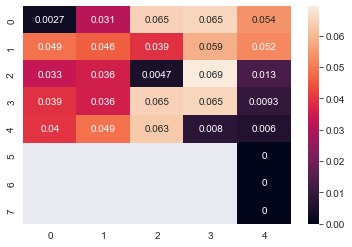

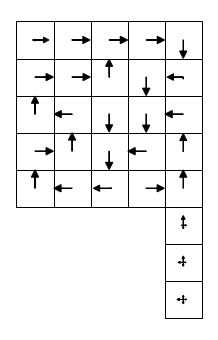

 75%|████████████████████████▊        | 24000/32000 [3:51:35<1:14:33,  1.79it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


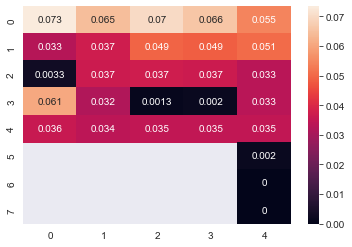

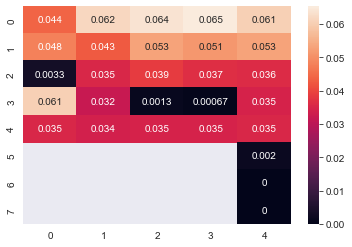

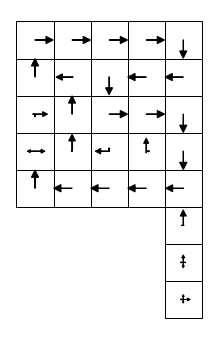

100%|███████████████████████████████████| 32000/32000 [5:05:05<00:00,  2.42it/s]

Final True State Distribution:
Final Believed State Distribution:
Ending Policy:


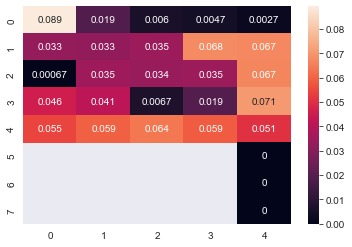

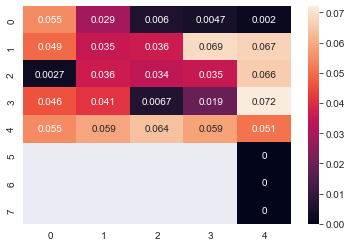

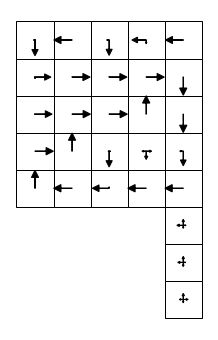

100%|███████████████████████████████████| 32000/32000 [5:05:06<00:00,  1.75it/s]


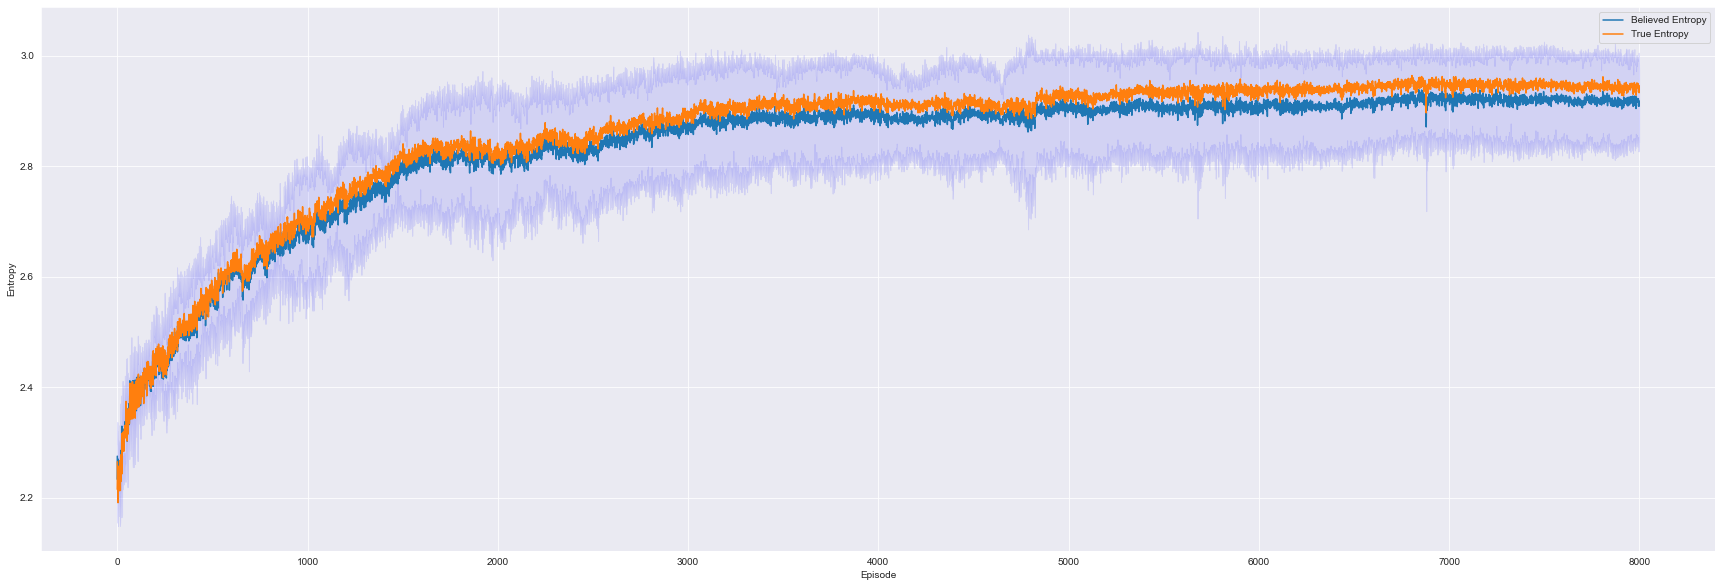

In [30]:
# Number of episodes for the training
n_episodes = 8000
n_traj = 50
# Number of runs per episode
n_run = 4
confidence = 0.95
time_horizon = 30
env = GridworldPOMDPEnvBiModal(time_horizon = time_horizon, steepness=15, prob=0)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    list_true_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentEPOMDP(env, alpha = 0.5)
        avg_entropies = []
        avg_true_entropies = []
        for i in range(n_episodes):
            episodes, true_entropies = agent.play(env=env, n_traj=n_traj)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            avg_true_entropies.append(np.mean(true_entropies))
            pbar.update(1)
        agent.print_visuals(env=env, n_traj=n_traj)
        list_entropies.append(avg_entropies)
        list_true_entropies.append(avg_true_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))
    list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence)

In [ ]:
# Number of episodes for the training
n_episodes = 8000
n_traj = 50
# Number of runs per episode
n_run = 3
confidence = 0.95
time_horizon = 30
env = GridworldPOMDPEnvBiModal(time_horizon = time_horizon, steepness=15, prob=0, randomize=1)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    list_true_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentEPOMDP(env, alpha = 0.5)
        avg_entropies = []
        avg_true_entropies = []
        for i in range(n_episodes):
            episodes, true_entropies = agent.play(env=env, n_traj=n_traj)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            avg_true_entropies.append(np.mean(true_entropies))
            pbar.update(1)
        agent.print_visuals(env=env, n_traj=n_traj)
        list_entropies.append(avg_entropies)
        list_true_entropies.append(avg_true_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))
    list_true_entropies = np.transpose(np.array(list_true_entropies), (1,0))

plot_graph(n_run, n_episodes, list_entropies, list_true_entropies, confidence)